In [1]:
import numpy as np
import csv
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.5.0


In [2]:
!wget "https://s3-ap-southeast-1.amazonaws.com/he-public-data/dataset52a7b21.zip" 

--2021-07-30 16:31:14--  https://s3-ap-southeast-1.amazonaws.com/he-public-data/dataset52a7b21.zip
Resolving s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)... 52.219.36.25
Connecting to s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)|52.219.36.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1061576029 (1012M) [binary/octet-stream]
Saving to: ‘dataset52a7b21.zip’

dataset52a7b21.zip  100%[===================>]   1012M  13.0MB/s    in 82s     

2021-07-30 16:32:38 (12.3 MB/s) - ‘dataset52a7b21.zip’ saved [1061576029/1061576029]



In [3]:
!unzip /content/dataset52a7b21.zip

Archive:  /content/dataset52a7b21.zip
   creating: dataset/
  inflating: dataset/train.csv       
  inflating: dataset/sample_submission.csv  
  inflating: dataset/test.csv        
  inflating: dataset/.~lock.train.csv#  


In [4]:
train_df=pd.read_csv('dataset/train.csv',escapechar = "\\",quoting = csv.QUOTE_NONE)

In [5]:
x = train_df['TITLE']

In [6]:
x[1]#type(x[1])

'The New Yorker NYHM014 Refrigerator Magnet, 2 x 3.5'

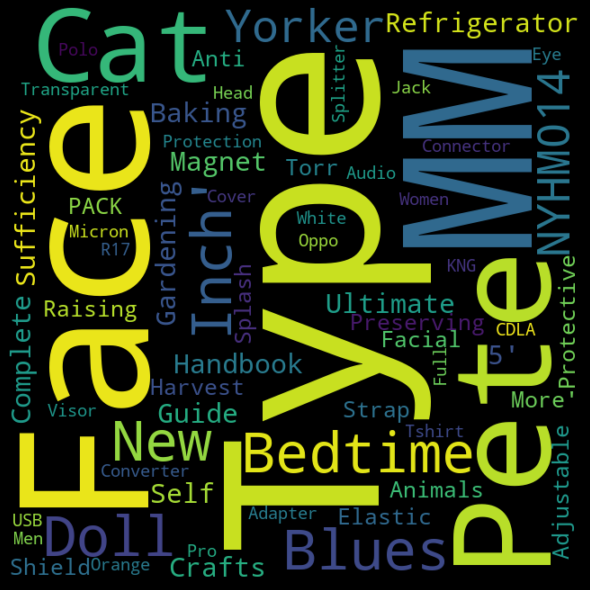

In [7]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
comments = train_df['TITLE'].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [8]:
train_df.columns

Index(['TITLE', 'DESCRIPTION', 'BULLET_POINTS', 'BRAND', 'BROWSE_NODE_ID'], dtype='object')

In [9]:
y = train_df['BROWSE_NODE_ID']

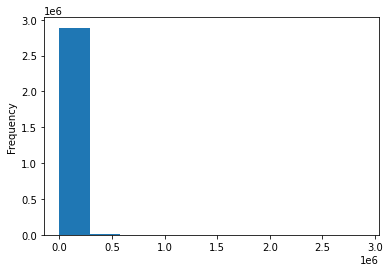

In [10]:
train_df['BROWSE_NODE_ID'].plot(kind='hist') # so most of the node ids are between 0 and 0..3e6. This is the kind of biased train data we are given.

In [11]:
max_features = 20000
max_text_length = 400#find the text with max length in code and change it for each column

In [21]:
x_tokenizer =text.Tokenizer(max_features)
x_tokenizer.fit_on_texts(list(str(x)))
x_tokenized = x_tokenizer.texts_to_sequences(str(x))
x_train_val = sequence.pad_sequences(x_tokenized, maxlen=max_text_length)

In [22]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-07-30 16:45:17--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-30 16:45:17--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-30 16:45:18--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [23]:
embedding_dim = 100
embedding_index = dict()
f = open('glove.6B.300d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    word_vectors[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(word_vectors))

Loaded 400000 word vectors.


In [27]:
'''EMBEDDING_DIM=300
vocabulary_size=min(len(word_index)+1,(NUM_WORDS))

embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))


for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        vec = np.zeros(EMBEDDING_DIM)

del(word_vectors)#to free up space'''

NameError: ignored

In [28]:
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, index in x_tokenizer.word_index.items():
  if index>max_features -1:
    break
  else:
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector


In [71]:
model = Sequential()
model.add(Embedding(max_features,
                    embedding_dim,
                    embeddings_initializer=tf.keras.initializers.Constant(
                        embedding_matrix),trainable=False))
model.add(Dropout(0.2))


In [72]:
#del(embedding_matrix)

### Building The Model

In [44]:
filters = 250
kernel_size = 3
hidden_dims = 250

In [45]:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid'))
model.add(MaxPooling1D())
model.add(Conv1D(filters,
                 5,
                 padding='valid',
                 activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1,activation='sigmoid'))
model.summary()

ValueError: ignored

Train Model

In [48]:
'''x_train, x_val, y_train, y_val = train_test_split(x_train_val,
                                                  y,
                                                  test_size=0.15,
                                                  random_state=1)'''

ValueError: ignored

In [50]:
'''%%time
batch_size = 32
epocha = 3

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=3,
          validation_data=(x_val,y_val))'''

NameError: ignored

In [69]:
sequence_length = train_df.shape[1]
filter_sizes = [3,4]
num_filters = 100
drop = 0.4

inputs = Input(shape=(sequence_length,))
embedding = embedding_layer(inputs)
reshape = Reshape((sequence_length,EMBEDDING_DIM,1))(embedding)

conv_0 = Conv2D(num_filters, (filter_sizes[0], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)
conv_1 = Conv2D(num_filters, (filter_sizes[1], EMBEDDING_DIM),activation='relu',kernel_regularizer=regularizers.l2(0.01))(reshape)

maxpool_0 = MaxPooling2D((sequence_length - filter_sizes[0] + 1, 1), strides=(1,1))(conv_0)
maxpool_1 = MaxPooling2D((sequence_length - filter_sizes[1] + 1, 1), strides=(1,1))(conv_1)

merged_tensor = concatenate([maxpool_0, maxpool_1], axis=1)
flatten = Flatten()(merged_tensor)
reshape = Reshape((2*num_filters,))(flatten)
dropout = Dropout(drop)(flatten)
conc = Dense(40)(dropout)
output = Dense(units=6, activation='sigmoid',kernel_regularizer=regularizers.l2(0.01))(conc)

# this creates a model that includes
model = Model(inputs, output)

NameError: ignored

In [ ]:
opt = Adam(lr=1e-3)
model.compile(loss='categorical_crossentropy',optimizer=opt)

# Fitting Model to the data
callbacks = [EarlyStopping(monitor='val_loss')]
hist_adam = model.fit(X_train, y_train, batch_size=1000, epochs=20, verbose=2, validation_data=(X_val, y_val),
         callbacks=callbacks)

NameError: ignored

NameError: ignored

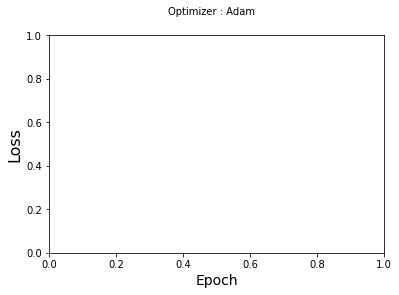

In [ ]:
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.plot(hist_adam.history['loss'], color='b', label='Training Loss')
plt.plot(hist_adam.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

In [ ]:
sequences_test=tokenizer.texts_to_sequences(X_test)
X_test2 = pad_sequences(sequences_test,maxlen=X_train.shape[1])

NameError: ignored

In [ ]:
col = ['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']

# Predict on train, val and test datasets
pred_train = model.predict(X_train)
pred_test = model.predict(X_test2)
pred_val = model.predict(X_val)

# Emply array to collect AUC scores
AUC = np.zeros((3,6))
AUC


NameError: ignored

In [ ]:
from sklearn import metrics
for i,x in enumerate(col):
    auc = np.array([metrics.roc_auc_score(y_train[:,i], pred_train[:,i]),
                    metrics.roc_auc_score(y_val[:,i], pred_val[:,i]),
                    metrics.roc_auc_score(y_test[x], pred_test[:,i])])
    print(x,"Train AUC:",auc[0],", Val AUC:",auc[1],", Test AUC:",auc[2])
    AUC[:,i] = auc
    
avg_auc = AUC.mean(axis=1)
print("Average Train AUC:",avg_auc[0],", Average Val AUC:",avg_auc[1],", Average Test AUC:",avg_auc[2])

NameError: ignored